In [20]:
import torch
from PIL import Image
import torchvision
from torchvision import transforms
from torchvision.models.detection import fasterrcnn_resnet50_fpn
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from pprint import pprint

In [2]:
MODEL_PATH = "../models/detection/fasterrcnn_4e.pth"
device = "cpu"

In [3]:
model = fasterrcnn_resnet50_fpn(pretrained=False)
in_features = model.roi_heads.box_predictor.cls_score.in_features
num_classes = 257
model.roi_heads.box_predictor = (
    torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)
)

/Users/pasha/.pyenv/versions/3.12.2/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/pasha/.pyenv/versions/3.12.2/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [4]:
model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
model.to(device)
model.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu

In [5]:
CATEGORIES_FN = "../data/UECFOOD256/category.txt"

with open(CATEGORIES_FN, "r") as file:
    data = file.readlines()

    id2name = {}
    for i in range(1, len(data)):
        category_id, category_name = data[i].split("\t")
        label_id, name = int(category_id), category_name.strip()
        id2name[label_id] = name

id2name

{1: 'rice',
 2: 'eels on rice',
 3: 'pilaf',
 4: "chicken-'n'-egg on rice",
 5: 'pork cutlet on rice',
 6: 'beef curry',
 7: 'sushi',
 8: 'chicken rice',
 9: 'fried rice',
 10: 'tempura bowl',
 11: 'bibimbap',
 12: 'toast',
 13: 'croissant',
 14: 'roll bread',
 15: 'raisin bread',
 16: 'chip butty',
 17: 'hamburger',
 18: 'pizza',
 19: 'sandwiches',
 20: 'udon noodle',
 21: 'tempura udon',
 22: 'soba noodle',
 23: 'ramen noodle',
 24: 'beef noodle',
 25: 'tensin noodle',
 26: 'fried noodle',
 27: 'spaghetti',
 28: 'Japanese-style pancake',
 29: 'takoyaki',
 30: 'gratin',
 31: 'sauteed vegetables',
 32: 'croquette',
 33: 'grilled eggplant',
 34: 'sauteed spinach',
 35: 'vegetable tempura',
 36: 'miso soup',
 37: 'potage',
 38: 'sausage',
 39: 'oden',
 40: 'omelet',
 41: 'ganmodoki',
 42: 'jiaozi',
 43: 'stew',
 44: 'teriyaki grilled fish',
 45: 'fried fish',
 46: 'grilled salmon',
 47: 'salmon meuniere',
 48: 'sashimi',
 49: 'grilled pacific saury',
 50: 'sukiyaki',
 51: 'sweet and sour

In [25]:
transform = transforms.Compose(
    [
        transforms.ToTensor(),
    ]
)


def predict(image_path, threshold=0.06):
    image = Image.open(image_path).convert("RGB")
    image_tensor = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        prediction = model(image_tensor)

    pred_boxes = prediction[0]["boxes"]
    pred_scores = prediction[0]["scores"]
    pred_labels = prediction[0]["labels"]
    pprint([id2name[x] for x in pred_labels.numpy()])
    idx = torch.argmax(pred_scores)
    pred_boxes = pred_boxes[idx]
    pred_scores = pred_scores[idx]
    pred_labels = pred_labels[idx]

    return image, pred_boxes, pred_labels, pred_scores


def plot_prediction(image, boxes, labels, scores):
    fig, ax = plt.subplots(1, figsize=(12, 9))
    ax.imshow(image)

    for box, label, score in zip(boxes, labels, scores):
        x1, y1, x2, y2 = box
        rect = patches.Rectangle(
            (x1, y1), x2 - x1, y2 - y1, linewidth=2, edgecolor="r", facecolor="none"
        )
        ax.add_patch(rect)
        ax.text(
            x1 + 5,
            y1 - 15,
            f"Name: {id2name[label.item()].title()} \nIndex: {label.item()}\nScore: {score:.2f}",
            bbox=dict(facecolor="white", alpha=0.5),
            fontsize=10,
        )

    plt.axis("off")
    plt.show()

['fried pork dumplings served in soup',
 'xiao long bao',
 'coconut milk soup',
 'Steamed rice roll']


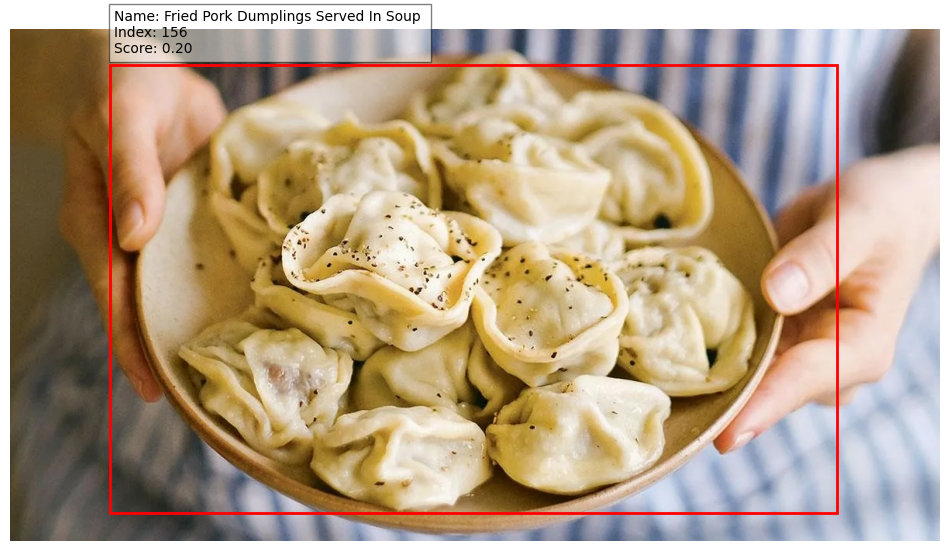

CPU times: user 5.08 s, sys: 2.67 s, total: 7.75 s
Wall time: 1.11 s


In [28]:
%%time
img_path = "1.jpg"
img, boxes, labels, scores = predict(img_path)
plot_prediction(img, [boxes], [labels], [scores])